## Neural networks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io 
import scipy.misc 
import matplotlib.cm as cm 
import random 
from scipy.special import expit as sigmoid
#sigmoid will be vectorized

In [2]:
#how to work with .mat files in python.
#training set of handwritten digits
data = 'ex3data1.mat'
mat = scipy.io.loadmat(data)

X, Y= mat['X'], mat['y']

X[1][:]    1first row, which represents a training example:
each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector.

#### 1.2 Visualizing the data

This was a very good exercise in data manipulation, i learned a lot. i had to take out my pen and paper to work it out and it took quite some time to implement it. But now i feel more confident manipulating any information contained in a big fat matrix.

In [3]:
def display_data(X,Y,sample_rows=100):
    #sample rows has to be square
    
    width=20
    height=20

    row_dim=int(np.sqrt(sample_rows)*height)
    col_dim=row_dim

    matrix=np.zeros((row_dim,col_dim)).astype(float)

    random_index=random.sample(range(0,4000), sample_rows)

    row_i=0
    col_i=0
    for i in random_index:
        

        random_row=X[i][:]
        X_row_matrix=np.reshape(random_row,(20,20)).T

        matrix[ height*row_i : height*(row_i+1) , width*col_i : width*(col_i+1)]=X_row_matrix
        #the submatrix shape will be 20 by 20. and from a given row, it will go columnwise
        #(as opposed to the converse, namely that for a given column, go row-wise)
        #there probably exists a name for this but i dont know it. drawing pictures help.
        #for this submatrix (that is populated by zeros), assign it the X_row_matrix

        col_i+=1
        #for the given row_i, increment col_i

        if col_i==matrix.shape[1]/height:
            #i,e we have looped through col_i until the end of the col_dim
          
            row_i+=1
            col_i=0
            #then we want to reset the col index and start on a new row

            #we do not need the same kind of reset-mechanism on row_i since random_index, by construction, has just the correct length

    return matrix


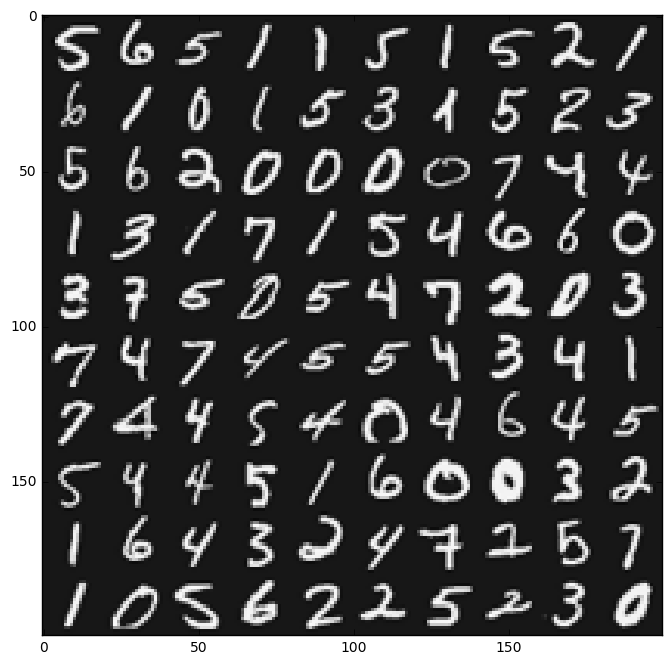

In [4]:
tst_matrix=display_data(X,Y)
fig = plt.figure(figsize=(8,8))
img_matrix=scipy.misc.toimage(tst_matrix)
plt.imshow(img_matrix,cmap=plt.cm.Greys_r, interpolation='none')
plt.show()

#### 1.3 Vectorizing Logistic Regression

"You can use your code in the last exercise as a starting point
for this exercise."-pdf

#### 1.3.1 Vectorizing the cost function

In [5]:
def cost_function2(theta_array, X,Y, l=0):
    m=len(Y)
    h_x=sigmoid(np.dot(X,theta_array.T))

    term1=np.dot(np.log(h_x),-Y.T)
    term2=np.dot(np.log(1-h_x),(1-Y).T)
    
    cost_regu=(term1-term2)/m +(l/(2*m))*np.dot(theta_array[1:].T,theta_array[1:])
    #import math
    #if math.isnan(cost_regu):
        #import pdb; pdb.set_trace()
    return cost_regu

#### 1.3.2 Vectorizing the gradient

In [6]:
def gradient_function(theta_array,X,Y, l=0):
    
    m=len(Y)
    
    sigmoid_theta_X=sigmoid(np.dot(X,theta_array))
    #this is similar to before, but now we use X instead of a row of X. hence sigmoid_theta_x will
    #be a 5000x1 vector
    
    gradient=np.dot(X.T,sigmoid_theta_X-Y)/m
    
    theta_array_regu=theta_array
    theta_array_regu[0]=0
    #this is a way to accomdoate that regularization does not apply to theta_array[0]
    gradient_regu=gradient + (l/m)*theta_array_regu
    
    return gradient_regu

#### 1.4 One-vs-all Classification

 my plan of attack is to write the code on how i would train one class (in particular, it it is a 0 or not 0? label for zero is y=10), 
and then generalize from there


In [8]:
#have to assign 1's column to X and make sure they are holding floats(to make the matrix operations work smoothly)
X=np.insert(X, 0, 1, axis=1)
X=X.astype(float)
Y=Y.astype(float)

401

In [9]:
#initalize thetas
theta_array=np.array([0 for i in range(X.shape[1])])


In [10]:

def g(y_label):

    def f(y):

        if y==y_label:
            return 1
        else:
            return 0
        
    return f    
    

In [11]:
Y_10=np.array(list(map(g(10), Y)))


In [13]:
#recall the black box optimizer for the cost function of logistic regression.
from scipy import optimize
def optimal_thetas(theta_array,X,Y,l=0, iterations=1000):
    result = optimize.fmin(cost_function2, x0=theta_array, args=(X, Y, l), maxiter=iterations, full_output=True)
    return result[0], result[1]



In [14]:
theta_array_opti, minimal_cost=optimal_thetas(theta_array,X,Y_10)

i ran into trouble here as it did not seem to converge after 10 min's worth of iterations  so i consulted another python-solution:
"
An alternative to OCTAVE's 'fmincg' we'll use some scipy.optimize function, "fmin_cg"
This is more efficient with large number of parameters.
In the previous homework, I didn't have to compute the cost gradient because
the scipy.optimize function did it for me with some kind of interpolation..."


In [22]:
def optimal_thetas_cg(theta_array,X,Y,l=0, iterations=2000):
    result = optimize.fmin_cg(cost_function2, fprime=gradient_function, x0=theta_array, args=(X, Y, l), maxiter=iterations,
                              full_output=True)
    return result[0], result[1]

In [23]:
theta_array_opti, minimal_cost=optimal_thetas_cg(theta_array,X,Y_10)

         Current function value: nan
         Iterations: 123
         Function evaluations: 1292
         Gradient evaluations: 1292


I had to do some serious debugging due to the message. the cost_function contains some nan-elements towards the end when it gets called. this is due to some of the elements in h_x being so small that they are -inf, so when they get multiplied by some number they become nan.

i take that the cost function to be  monotonically decreasing (disregarding the nans) to be a good sign, and it is also good that it tends to zero, given that this tendency does not affect the out of sample error. i think this means that the classifier does not make any misclassifications on the training set. however it is true that getting 0 error in sample does NOT imply that the out of sample error is low.

i think we could say something about the probability that the out of sample-error is close to the in sample-error(which is close to 0, so that would imply that the out of sample error would be zero, which is desirable) if i could work out what  maximum number of dichotomies (i,e the growth function) are possible under the current hypothesis set. the hypothesis set is the family of functions defined by h_theta(x)=sigmoid(np.dot(theta_array,x)). this is a theoretical question and maybe something i could answer once i've learned more theory. 

 this specifik theta_array_opti corresponds to the last row in the theta_matrix that should be returned in the general case.

### Time to generalize!

In [33]:

def one_vs_all(theta_array,X,Y, K=10, tol=1):
    
    labels=list(range(1,K+1))
    #in some other circumstance the labels should be retrived from  the Y array
    theta_matrix=np.zeros((K,X.shape[1]))
    
    for label in labels:
        Y_labeled=np.array(list(map(g(label), Y)))
        theta_array_opti, minimal_cost=optimal_thetas_cg(theta_array,X,Y_labeled)
    
        theta_matrix[label-1]=theta_array_opti
    
    return theta_matrix

In [35]:
theta_matrix=one_vs_all(theta_array,X,Y)

Optimization terminated successfully.
         Current function value: 0.000363
         Iterations: 140
         Function evaluations: 664
         Gradient evaluations: 664
         Current function value: nan
         Iterations: 2000
         Function evaluations: 46296
         Gradient evaluations: 46296
         Current function value: nan
         Iterations: 2000
         Function evaluations: 60147
         Gradient evaluations: 60147
         Current function value: nan
         Iterations: 2000
         Function evaluations: 68651
         Gradient evaluations: 68651
Optimization terminated successfully.
         Current function value: 0.029895
         Iterations: 1023
         Function evaluations: 3371
         Gradient evaluations: 3371
         Current function value: nan
         Iterations: 204
         Function evaluations: 1337
         Gradient evaluations: 1337
         Current function value: nan
         Iterations: 268
         Function evaluations: 2684
    

took about 10 minutes! the 6th optimization evaluated the function 1337 times, so the classifier for "6 or not 6" might be elite.

In [37]:
theta_matrix

array([[ -6.54052180e+00,   0.00000000e+00,   0.00000000e+00, ...,
          2.58086414e-02,   2.59643938e-07,   0.00000000e+00],
       [ -5.85861352e+00,   0.00000000e+00,   0.00000000e+00, ...,
          1.86636351e-01,  -1.09650218e-02,   0.00000000e+00],
       [ -8.27371854e+00,   0.00000000e+00,   0.00000000e+00, ...,
         -1.89596604e-04,   3.53248297e-07,   0.00000000e+00],
       ..., 
       [ -2.40941524e-01,   0.00000000e+00,   0.00000000e+00, ...,
         -1.20246700e-06,   1.24116545e-07,   0.00000000e+00],
       [ -7.95860900e+00,   0.00000000e+00,   0.00000000e+00, ...,
         -6.27245611e-02,   3.93358495e-03,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
         -4.95461423e-04,   2.24929927e-05,   0.00000000e+00]])

In [92]:
sigmoid(np.dot(theta_matrix,X[0]))

def predict(theta_matrix,X,row):
    #row is the number that corresponds to  X's row
    
    X_pic=X[:,1:]
    #^^need to get rid of 1's  for the picture
    X_row=X_pic[row][:]
    X_row_matrix=np.reshape(X_row,(20,20)).T
    
    fig = plt.figure(figsize=(2,2))
    img_matrix=scipy.misc.toimage(X_row_matrix)
    plt.imshow(img_matrix,cmap=plt.cm.Greys_r, interpolation='none')
    plt.show()
    print('above is the input and below the prediction')
    
    
    prediction_array=sigmoid(np.dot(theta_matrix,X[row]))
    
    max_value=max(prediction_array)
    
    for i in range(len(prediction_array)):
        if prediction_array[i]==max_value:
            max_value_index=i
            
    print(('the algorithm assigns max value: {max_value} to class: {max_value_index} ').format(max_value=max_value, max_value_index=max_value_index+1))        


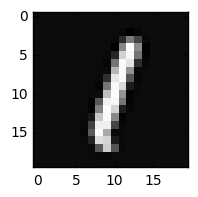

above is the input and below the prediction
the algorithm assigns max value: 0.9999998478243263 to class: 1 


In [93]:
predict(theta_matrix,X,886)

In [91]:
predict(theta_matrix,X,286)

array([  9.99999848e-01,   1.47550869e-03,   3.69675759e-04,
         6.88203182e-08,   8.24686550e-10,   2.93106490e-10,
         3.91930382e-03,   4.76049873e-02,   1.80150141e-04,
         2.50854434e-17])